# PyTorch Computer Vision

## 0. Computer Vision libraries in PyTorch

* `torchvision` - base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision here
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with an image model.
* `torch.utils.data.Dataset` - Base dataset class for PyTorch
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset.

In [74]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

## 1. Getting a dataset

The dataset we'll be using is the FashionMNIST.

In [75]:
# Setup training data
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root="data",            # Where to download the data
    train=True,             # Do we want the training dataset
    download=True,          # Do we want to download it
    transform=torchvision.transforms.ToTensor(),    # How do we want to transform the data
    target_transform=None   # How do we want to transform the output/labels
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

In [76]:
len(train_data), len(test_data)

(60000, 10000)

In [77]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [78]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [79]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [80]:
# Check the shape of our image
image, label = train_data[0]        # Image is in color channels * height * width
image.shape, label

(torch.Size([1, 28, 28]), 9)

## 1.2 Visualizing our data

Image shape: torch.Size([1, 28, 28])


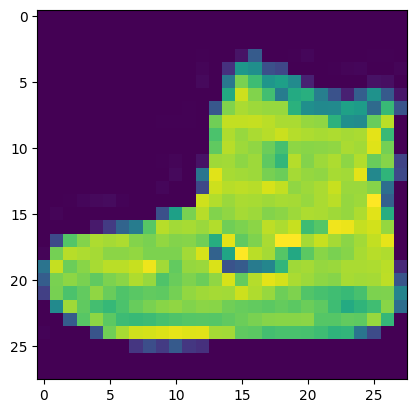

In [81]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())

(-0.5, 27.5, 27.5, -0.5)

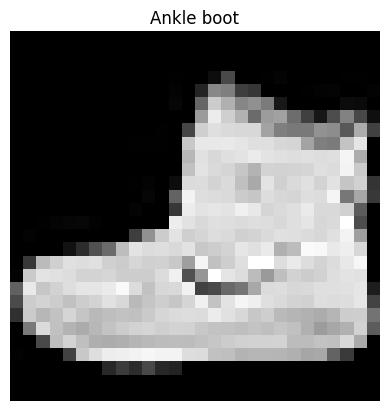

In [82]:
# Plotting in grayscale
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

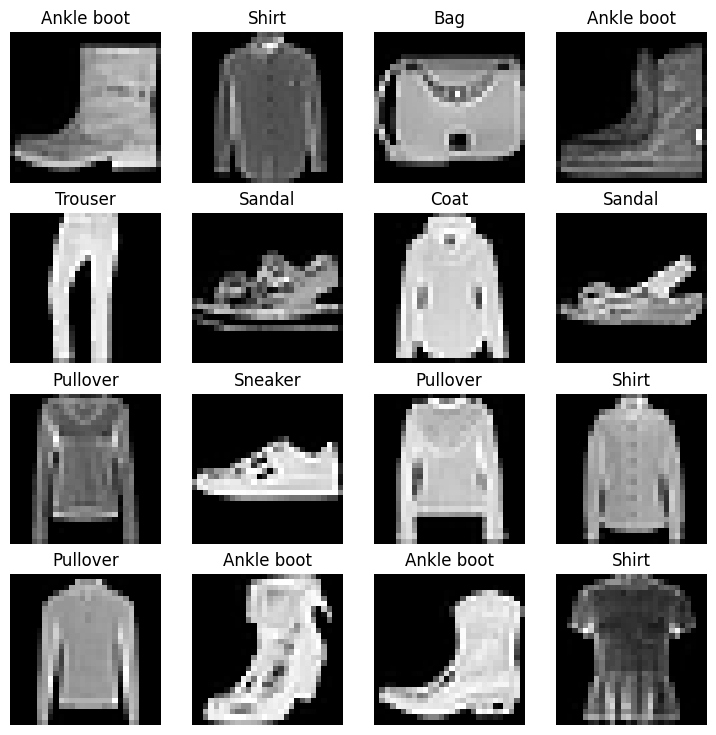

In [83]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()     # size=[1] means 1 random integer in a tensor, .item() to get the python integer from the tensor
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## 2. Prepare DataLoader

Our data is in the form of PyTorch Datasets.

DataLoader turns our dataset into a Python iterable.

More specifically, we want to turn our data into batches/mini-batches.

Why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look at 60000 images in one hit. So we break it down to 32 images at one time (batch size = 32).

2. It gives our neural network more chances to update it's gradients per epoch.

In [84]:
from torch.utils.data import DataLoader 

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [85]:
# Let's check what we've created 
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x000002793F71C670>, <torch.utils.data.dataloader.DataLoader object at 0x000002793F71E020>)
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [86]:
# Check out what's inside training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6, label_size=torch.Size([])


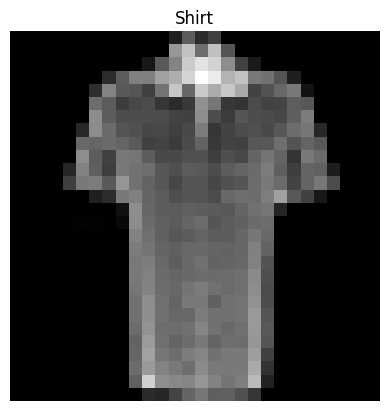

In [87]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label_size={label.shape}")

## 3. Model 0: Make a baseline model

When starting to build a series of machine learning modelling experiments. it's best practice to start with a baseline model.

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary.

In [88]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x)       # Perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape}")            # Colour channels, height, width
print(f"Shape after flattening: {output.shape}")        # Colour channels,, height * width
# We flatten it as we're applying a linear layer to the data and a linear layer can't handle multi-dimensional input

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [89]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [90]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=784,        # 28 x 28
    hidden_units=10,
    output_shape=len(class_names)       # One for every class
).to('cpu')

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [91]:
dummy_x = torch.rand([1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [92]:
model_0.state_dict()                # Has weights and biases

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
* Optimizer - our optimizer `torch.optim.SGD()`
* Evaluation metric - since we're working on a classification problem, let's use accuracy as our evaluation metric.

In [93]:
import requests
from pathlib import Path

# Downloading helper functions
if Path('helper_functions.py').is_file():
    print("helper_functions.py already exists, skipping download.")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

helper_functions.py already exists, skipping download.


In [94]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### 3.2 Creating a function to time our experiments

Machine learning is very experimental.

2 of the main things you'll often want to track:
1. Model's performance (loss & accuracy values etc.)
2. How fast it runs

In [95]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device=None):
    """"Prints difference between start and end time"""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [96]:
start_time = timer()
# Some code
end_time = timer()
print_train_time(start_time, end_time, device="cpu")

Train time on cpu: 0.000 seconds


4.2199972085654736e-05

### 3.3 Creating a training loop and training a model on batches of data.

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the training loss **per batch**.
3. Loop through testing batches, perform testing steps, calculate the test loss **per batch**.
4. Print out what's happening.
5. Time it all.

In [97]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n")
    ### Training
    train_loss = 0
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)
        
        # 2. Calculate the loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss          # Accumulate training loss
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
    
        # Print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)}")
        
    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)             # Avg loss/epoch in a batch
    
    ### Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X_test)
            
            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y_test)
            
            # 3. Calculate accuracy
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))  # argmax to get the highest probability outcome
        
        # Calculate the test loss average/batch
        test_loss /= len(test_dataloader)              
        
        # Calculate the test acc average/batch
        test_acc /= len(test_dataloader)
        
    # Print out what's happening
    print(f"\nTrain Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

# Calculate train time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu, device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0

Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000

Train Loss: 0.5904 | Test Loss: 0.5095 | Test Acc: 82.04%
Epoch: 1

Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000

Train Loss: 0.4763 | Test Loss: 0.4799 | Test Acc: 83.20%
Epoch: 2

Looked at 0/60000
Looked at 12800/60000
Looked at 25600/60000
Looked at 38400/60000
Looked at 51200/60000

Train Loss: 0.4550 | Test Loss: 0.4766 | Test Acc: 83.43%
Train time on cpu: 31.639 seconds


## 4. Make predictions and get Model 0 results

In [98]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of a model predicting on data loader."""
    loss, acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values / batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc to find the average loss or acc / batch
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {'model_name': model.__class__.__name__,     # Only works when model was created with a class
            'model_loss': loss.item(),
            'model_acc': acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 5. Setup device agnostic code

In [99]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 6. Model 1: Building a better model with non-linearity

In [100]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),       # Flattens input to a single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [101]:
# Create an instance of model_1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,          # Output of the flatten layer after our 28x28 image goes in
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
next(model_1.parameters()).device

device(type='cpu')

### 6.1 Setup loss, optimizer and evaluation metrics

In [102]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()         # Measures how wrong our model is
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)        # Updates our model params to reduce loss

### 6.2 Functionalizing training and evaluation/testing loops
Let's create a function for:
* training loop - `train_step()`
* testing loop - `test_step()`

In [103]:
def train_step(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """Performs a training loop step on model trying to learn on dataloader"""
    train_loss, train_acc = 0, 0
    
    # Put model into training model
    model.train()
    
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass (outputs the raw logits from the model)
        y_pred = model(X)
        
        # 2. Calculate loss and accuracy / batch
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step (updating parameters once/batch)
        optimizer.step()
        
    # Divide total train loss and acc by length of train_dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}%")

In [104]:
def test_step(model: torch.nn.Module, 
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, 
              accuracy_fn, 
              device: torch.device = device):
    """Performs a testing loop step on model going over data_loader"""
    test_loss, test_acc = 0, 0
    
    # Put the model in eval mode
    model.eval()
    
    # Turn on inference mode
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate the loss/acc
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))   # logits -> prediction labels
            
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%")

In [105]:
# We can run the train and test step inside a for loop for each epoch

torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----")
    train_step(data_loader=train_dataloader, model=model_1, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)
    test_step(data_loader=test_dataloader, model=model_1, loss_fn=loss_fn, accuracy_fn=accuracy_fn)

train_time_end = timer()
total_train_time_end_model_1 = print_train_time(start=train_time_start, end=train_time_end, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----
Train loss: 1.0920 | Train acc: 61.34%
Test loss: 0.9564 | Test acc: 65.00%
Epoch: 1
----
Train loss: 0.7810 | Train acc: 71.93%
Test loss: 0.7223 | Test acc: 73.91%
Epoch: 2
----
Train loss: 0.6703 | Train acc: 75.94%
Test loss: 0.6850 | Test acc: 75.02%
Train time on cpu: 30.679 seconds


### Evaluating our model

In [106]:
# Defining define agnostic evaluation model
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [107]:
torch.manual_seed(42)

model_1_results = eval_model(model=model_1, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [108]:
model_0_results             # Comparing with baseline results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

Comparing, we can conclude that adding non-linearity reduced the model performance.

What can we do to improve the performance?
1. Use a different model
2. Use a larger dataset

Let's start with using a different model

## 7. Building a Convolutional Neural Network (CNN)

We will use TinyVGG (a CNN model) to classify the images.

It follows the typical structure of a CNN: `Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> Output layer`, where the contents of `[Convolutional layer -> activation layer -> pooling layer]` can upscale multiple times depending on the requirement.

In [109]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### 7.1: Stepping through `nn.Conv2d()`
We use `nn.Conv2d()` for images and videos, `nn.Conv1d()` for text and `nn.Conv3d()` for 3D objects.

Let's test them out with some toy data.

In [110]:
torch.manual_seed(42)

# Create a sample batch of random numbers with size similar to image data
images = torch.randn(size=(32, 3, 64, 64))      # [batch_size, color channels, height, width]
test_image = images[0]
print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])


The parameters of a `Conv2d` layer:
* in_channels (int) - Number of channels in the input image.
* out_channels (int) - Number of channels produced by the convolution.
* kernel_size (int or tuple) - Size of the convolving kernel/filter.
* stride (int or tuple, optional) - How big of a step the convolving kernel takes at a time. Default: 1.
* padding (int, tuple, str) - Padding added to all four sides of input. Default: 0.

In [111]:
torch.manual_seed(42)

conv_layer = nn.Conv2d(in_channels=3, out_channels=10,
                       kernel_size=3, stride=1, padding=0       # padding='VALID' doesn't add padding and drops the end layers if necessary. padding='SAME' adds equal amount of padding to all sides but adds extra padding to right if required
                       )
conv_layer(test_image), test_image.shape, conv_layer(test_image).shape

(tensor([[[ 1.5396,  0.0516,  0.6454,  ..., -0.3673,  0.8711,  0.4256],
          [ 0.3662,  1.0114, -0.5997,  ...,  0.8983,  0.2809, -0.2741],
          [ 1.2664, -1.4054,  0.3727,  ..., -0.3409,  1.2191, -0.0463],
          ...,
          [-0.1541,  0.5132, -0.3624,  ..., -0.2360, -0.4609, -0.0035],
          [ 0.2981, -0.2432,  1.5012,  ..., -0.6289, -0.7283, -0.5767],
          [-0.0386, -0.0781, -0.0388,  ...,  0.2842,  0.4228, -0.1802]],
 
         [[-0.2840, -0.0319, -0.4455,  ..., -0.7956,  1.5599, -1.2449],
          [ 0.2753, -0.1262, -0.6541,  ..., -0.2211,  0.1999, -0.8856],
          [-0.5404, -1.5489,  0.0249,  ..., -0.5932, -1.0913, -0.3849],
          ...,
          [ 0.3870, -0.4064, -0.8236,  ...,  0.1734, -0.4330, -0.4951],
          [-0.1984, -0.6386,  1.0263,  ..., -0.9401, -0.0585, -0.7833],
          [-0.6306, -0.2052, -0.3694,  ..., -1.3248,  0.2456, -0.7134]],
 
         [[ 0.4414,  0.5100,  0.4846,  ..., -0.8484,  0.2638,  1.1258],
          [ 0.8117,  0.3191,

In [112]:
# Trying different values for conv layer
torch.manual_seed(42)

conv_layer_2 = nn.Conv2d(in_channels=3, # same number of color channels as our input image
                         out_channels=10,
                         kernel_size=(5, 5), # kernel is usually a square so a tuple also works
                         stride=2,
                         padding=0)

# Pass single image through new conv_layer_2 (this calls nn.Conv2d()'s forward() method on the input)
test_image.shape, conv_layer_2(test_image).shape

(torch.Size([3, 64, 64]), torch.Size([10, 30, 30]))

Shape of the image changes from `[3, 64, 64]` -> `[10, 30, 30]`

Conv layer compresses the information.

In [113]:
# Checking our conv layer's state dict
conv_layer_2.state_dict()

OrderedDict([('weight',
              tensor([[[[ 0.0883,  0.0958, -0.0271,  0.1061, -0.0253],
                        [ 0.0233, -0.0562,  0.0678,  0.1018, -0.0847],
                        [ 0.1004,  0.0216,  0.0853,  0.0156,  0.0557],
                        [-0.0163,  0.0890,  0.0171, -0.0539,  0.0294],
                        [-0.0532, -0.0135, -0.0469,  0.0766, -0.0911]],
              
                       [[-0.0532, -0.0326, -0.0694,  0.0109, -0.1140],
                        [ 0.1043, -0.0981,  0.0891,  0.0192, -0.0375],
                        [ 0.0714,  0.0180,  0.0933,  0.0126, -0.0364],
                        [ 0.0310, -0.0313,  0.0486,  0.1031,  0.0667],
                        [-0.0505,  0.0667,  0.0207,  0.0586, -0.0704]],
              
                       [[-0.1143, -0.0446, -0.0886,  0.0947,  0.0333],
                        [ 0.0478,  0.0365, -0.0020,  0.0904, -0.0820],
                        [ 0.0073, -0.0788,  0.0356, -0.0398,  0.0354],
                     

### 7.2: Stepping through `nn.MaxPool2d()`

In [114]:
print(f"Original test image shape: {test_image.shape}")

# Create a sample MaxPool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through the conv layer
test_image_through_conv = conv_layer(test_image)
print(f"Shape after going through conv layer: {test_image_through_conv.shape}")

 # Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv and maxpool layer: {test_image_through_conv_and_max_pool.shape}")

Original test image shape: torch.Size([3, 64, 64])
Shape after going through conv layer: torch.Size([10, 62, 62])
Shape after going through conv and maxpool layer: torch.Size([10, 31, 31])


As kernel size = 2 and stride = 2, the 2nd and 3rd layer are halved after the `MaxPool2d()` layer.

In [115]:
# Seeing the same with a smaller tensor

torch.manual_seed(42)

random_tensor=torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Passing the tensor through the maxpool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\n\nMax pool tensor:{max_pool_tensor} <- maximum value from our tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])


Max pool tensor:tensor([[[[0.3367]]]]) <- maximum value from our tensor
Max pool tensor shape: torch.Size([1, 1, 1, 1])


The dimensions halve from `[2, 2]` to `[1, 1]`. This would differ based on the values of `kernel_size` and `nn.MaxPool2d()`

> Basically each layer in a neural network is trying to compress data from higher dimensional space to lower dimensional space.

It takes in raw data (entire image), learns patterns that are predictive, retains them while being smaller in size than the original values.

From an AI perspective, the whole goal is to compress, yet preserve information.

So the `MaxPool2d()` simply takes the maximum value of from a portion of the tensor and disregards the rest. Lowering the dimensionality while also hopefully preserving the signficant portion of the information.

The `Conv2d()` layers performs a convolution operation, which gives us a feature map that highlights specific patterns, the `MaxPool2d()` layer then operates on this feature map.

Convolutions are calculated by computing the dot products.

E.g. for input image
\begin{matrix}
1, 2, 0 \\
4, 5, 6 \\
7, 8, 9
\end{matrix}

and a filter
\begin{matrix}
1, 0 \\
0, 1
\end{matrix}

Assuming `stride`=1 and `padding`=0, the operation will be performed as follows:
1. Filter at the top left position (to calculate `A11` of the feature map):
$ (1 * 1) + (2 * 0) + (4 * 0) + (1 * 5) = 6 $
2. Shift the filter right by 1 pixel (as stride=1) to compute the `A12` of feature map:
$ (2 * 1) + (0 * 0) + (5 * 0) + (6 * 1) = 8 $

Similarly we move the filter down 1 pixel and then left by 1 pixel to calculate `A21` and `A22` of the feature map.

The resulting feature map looks like:
\begin{matrix}
6, 8 \\
12, 14 \\
\end{matrix}

If there's a bias term, we add it to each element of the feature map and applying ReLU activation function.

Similarly, if we had a 4x4 matrix with stride = 1 and padding = 0, then we would have a 3x3 feature map.

### 7.3 Setup a loss function and optimizer for `model_2`

In [116]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

### 7.4: Training & Testing our model

In [117]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---")
    train_step(data_loader=train_dataloader, model=model_2, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, device=device)
    test_step(data_loader=test_dataloader, model=model_2, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2, end=train_time_end_model_2, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---
Train loss: 0.5905 | Train acc: 78.60%
Test loss: 0.3954 | Test acc: 86.17%
Epoch: 1
---
Train loss: 0.3596 | Train acc: 87.06%
Test loss: 0.3568 | Test acc: 86.91%
Epoch: 2
---
Train loss: 0.3241 | Train acc: 88.17%
Test loss: 0.3249 | Test acc: 88.24%
Train time on cpu: 83.572 seconds


In [118]:
# Evaluating our model
model_2_results = eval_model(model=model_2, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3249143064022064,
 'model_acc': 88.2388178913738}

## 8. Compare model results and training time

It is a common practice to build multiple models (training experiments) to see which one performs the best.

In [119]:
# Combining our model results dictionary into a dataframe
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.324914,88.238818


In [120]:
# Adding training time values, as they're an important factor too
compare_results['training_time'] = [total_train_time_model_0, total_train_time_end_model_1, total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,31.638696
1,FashionMNISTModelV1,0.685001,75.019968,30.678563
2,FashionMNISTModelV2,0.324914,88.238818,83.572035


Our CNN model performed the best but also took 3x more time to train as compared to our baseline model.

**Performance-Speed Tradeoff**: Generally, larger, more complex models perform better but this performance increase normally comes at the cost of training and inference speed.

Text(0, 0.5, 'Accuracy')

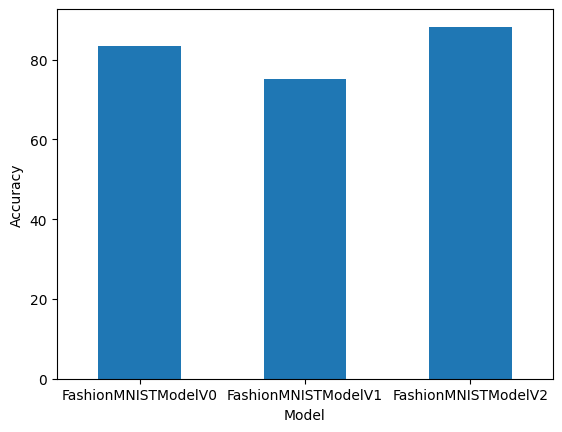

In [121]:
# Visualizing our model results
compare_results.set_index('model_name')['model_acc'].plot(kind='bar')
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.ylabel("Accuracy")

## 9. Make and evaluate random predictions with our best model

In [122]:
# Creating make_predictions() function

def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device)      # Adding an extra dimension, necessary for older PyTorch versions
            
            # Forward pass (model outputs raw logits)
            pred_logit = model(sample)
            
            # Get prediction probability (logits -> prediction probaility)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)  # NOTE: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)
            
            # Get pred prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
        
        # Stack the pred probs to turn list into tensor
        return torch.stack(pred_probs)

In [123]:
import random
torch.manual_seed(42)
test_samples = []
test_labels = []

# To get 9 random samples and labels from our test data
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the 1st test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 1 (Trouser)


In [124]:
# Make predictions on test samples with model 2
pred_probs = make_predictions(model=model_2, data=test_samples)

# View first 2 prediction probabilities list
pred_probs[:2]

tensor([[1.7820e-04, 9.9861e-01, 4.7618e-06, 4.5334e-04, 7.4014e-04, 1.7214e-07,
         7.3074e-06, 6.0210e-07, 1.8111e-06, 9.3726e-09],
        [1.8708e-05, 5.3221e-06, 8.7311e-06, 1.2389e-06, 8.6759e-06, 2.0702e-03,
         1.4519e-05, 9.7327e-01, 7.5234e-04, 2.3847e-02]])

In [125]:
# Get prediction labels from the prediction probabilities using argmax
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([1, 7, 3, 9, 9, 2, 9, 2, 4])

In [126]:
test_labels, pred_classes

([1, 7, 3, 9, 9, 2, 9, 2, 4], tensor([1, 7, 3, 9, 9, 2, 9, 2, 4]))

Our model predicted correctly 9/10 times. Let's visualize the same.

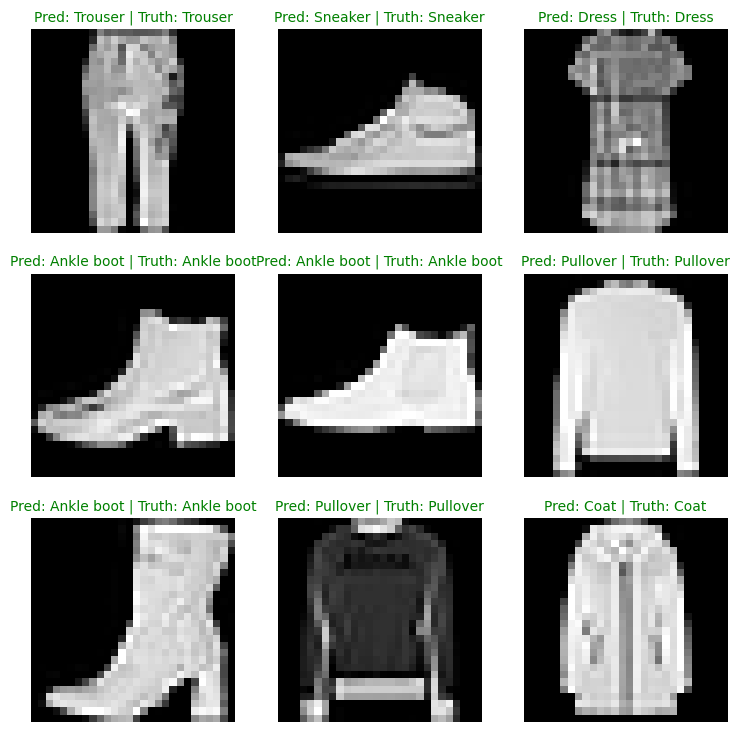

In [127]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows, ncols = 3, 3
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)
    
    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")
    
    # Find the prediction label (in text form, e.g. Sandal)
    pred_label = class_names[pred_classes[i]]
    
    # Get the truth label in text form
    truth_label = class_names[test_labels[i]]
    
    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    
    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False)

## 10. Making a confusion matrix for further prediction evaluation

In [128]:
# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [129]:
!pip install mlxtend -qqq

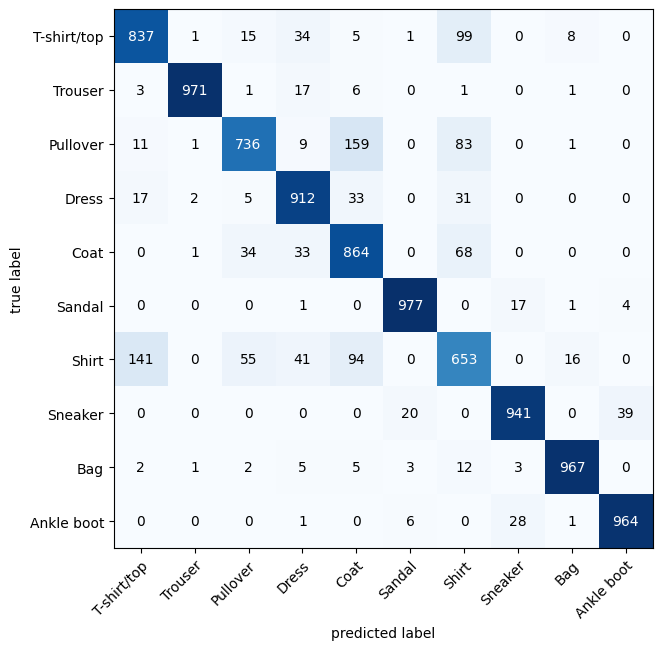

In [130]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),    # matplotlib likes working with NumPy 
    class_names=class_names,            # turn the row and column labels into class names
    figsize=(10, 7)
);

Some common errors are:
1. Pullovers are getting confused for coats
2. T-shirts getting confused for shirts and vice versa

## 11. Save and Load the best performing model

In [131]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)           # Creating models directory if it doesn't already exist

# Create model save path
MODEL_NAME = '03_pytorch_computer_vision_model_2.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),        # Only saving the state dict saves only the model parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\03_pytorch_computer_vision_model_2.pth


In [140]:
# Loading our model
loaded_model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=10)

# Load the state dict
loaded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Send model to GPU (if available)
loaded_model_2 = loaded_model_2.to(device)

In [142]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3249143064022064,
 'model_acc': 88.2388178913738}

In [143]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model_2_results["model_loss"]), 
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)